In [29]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
from tqdm import tqdm

sns.set_theme(style="darkgrid")
sns.set_context("talk")

In [2]:
memories_path = "usvsnsp/memories-semantic-memorization-filter-results"
memories_dataset = load_dataset(memories_path)
ordered_deduped_splits = [
    "memories.deduped.70m",
    "memories.deduped.160m",
    "memories.deduped.410m",
    "memories.deduped.1b",
    "memories.deduped.1.4b",
    "memories.deduped.2.8b",
    "memories.deduped.6.9b",
    "memories.deduped.12b",
]
ordered_duped_splits = [
    "memories.duped.70m",
    "memories.duped.160m",
    "memories.duped.410m",
    "memories.duped.1b",
    "memories.duped.1.4b",
    "memories.duped.2.8b",
    "memories.duped.6.9b",
    "memories.duped.12b",
]
split_to_param_count = {
    "70m": 70000000,
    "160m": 160000000,
    "410m": 410000000,
    "1b": 1000000000,
    "1.4b": 1400000000,
    "2.8b": 2800000000,
    "6.9b": 6900000000,
    "12b": 12000000000,
}
memories_dataset

DatasetDict({
    memories.deduped.1.4b: Dataset({
        features: ['sequence_id', 'text', 'sequence_duplicates', 'max_frequency', 'avg_frequency', 'min_frequency', 'median_frequency', 'p25_frequency', 'p75_frequency', 'frequencies', 'is_incrementing', 'tokens', 'repeating_offset', 'num_repeating', 'smallest_repeating_chunk', 'memorization_score', 'templating_frequency_0.9', 'templating_frequency_0.8', 'prompt_perplexity', 'generation_perplexity', 'sequence_perplexity'],
        num_rows: 1048097
    })
    memories.deduped.12b: Dataset({
        features: ['sequence_id', 'text', 'sequence_duplicates', 'max_frequency', 'avg_frequency', 'min_frequency', 'median_frequency', 'p25_frequency', 'p75_frequency', 'frequencies', 'is_incrementing', 'tokens', 'repeating_offset', 'num_repeating', 'smallest_repeating_chunk', 'memorization_score', 'templating_frequency_0.9', 'templating_frequency_0.8', 'prompt_perplexity', 'generation_perplexity', 'sequence_perplexity'],
        num_rows: 1871216


In [3]:
combined_dataframe = None
for split in tqdm(memories_dataset):
    current_dataset = memories_dataset[split]
    current_frame = current_dataset.to_pandas()
    current_frame["Model"] = ".".join(split.split(".")[2:])
    current_frame["Param Count"] = split_to_param_count[current_frame["Model"].iloc[0]]
    current_frame["Deduped"] = "deduped" in split
    if combined_dataframe is None:
        combined_dataframe = current_dataset.to_pandas()
    else:
        combined_dataframe = pd.concat([combined_dataframe, current_frame])

combined_dataframe.head()

100%|██████████| 16/16 [01:39<00:00,  6.21s/it]


,sequence_id,text,sequence_duplicates,max_frequency,avg_frequency,min_frequency,median_frequency,p25_frequency,p75_frequency,frequencies,...,smallest_repeating_chunk,memorization_score,templating_frequency_0.9,templating_frequency_0.8,prompt_perplexity,generation_perplexity,sequence_perplexity,Model,Param Count,Deduped
0,21590,"name=""n115"">115</a>\n<a href=""#n116"" name=""n1...",55,11740996961,9.379041e+08,3053059,277329702.0,20962725,395603541,"[74701064, 316219101, 277329702, 3550680, 7828...",...,[],1.0,22,130,1.598633,1.002930,1.603516,NaN,NaN,NaN
1,30252,195. \n 196. \n 197. \n 198. \n 199. \n ...,21482,10346382453,2.780063e+09,1869557,385281005.0,13592032,695610999,"[695610999, 2161549, 10346382453, 74951011, 69...",...,[],1.0,696,2333,1.178711,1.000000,1.178711,NaN,NaN,NaN
2,35232,TripAdvisor website may not display properly....,21829,11740996961,2.526616e+09,860666,42752068.5,6514834,1502731047,"[940429, 8644427, 1623266, 19127815, 170838448...",...,[],1.0,116,389,1.164062,1.013672,1.178711,NaN,NaN,NaN
3,62350,"\r\n __HAL_IRDA_DISABLE_IT(hirda, IRD...",10,9362638615,8.393529e+08,397964,16284663.0,4176692,918861018,"[86724122, 63456612, 21762340, 636295, 1659997...",...,[],1.0,1,1,1.933594,1.035156,2.001953,NaN,NaN,NaN
4,75902,/95/sel_9536 -1 2 [WORD] XX ...,1,11740996961,9.808267e+08,783155,216143855.5,43385287,909893795,"[816247750, 23811202, 816247750, 3092264, 1659...",...,[],1.0,18,329,1.779297,1.005859,1.791016,NaN,NaN,NaN


In [4]:
dev_frame = combined_dataframe
value_counts_frame = dev_frame[dev_frame["is_incrementing"] == True].value_counts(["Model"])
formatted_value_counts = {}
for key in value_counts_frame.keys():
    formatted_key = key[0]
    formatted_value_counts[split_to_param_count[formatted_key]] = value_counts_frame[key]

# sort keys in ascending order
formatted_value_counts = dict(sorted(formatted_value_counts.items()))
formatted_value_counts

{70000000: 134096,
 160000000: 180111,
 410000000: 225216,
 1000000000: 265919,
 1400000000: 175695,
 2800000000: 317451,
 6900000000: 359732,
 12000000000: 383451}

<Axes: title={'center': 'Incrementing Memories by Model Size'}, xlabel='Parameter Count'>

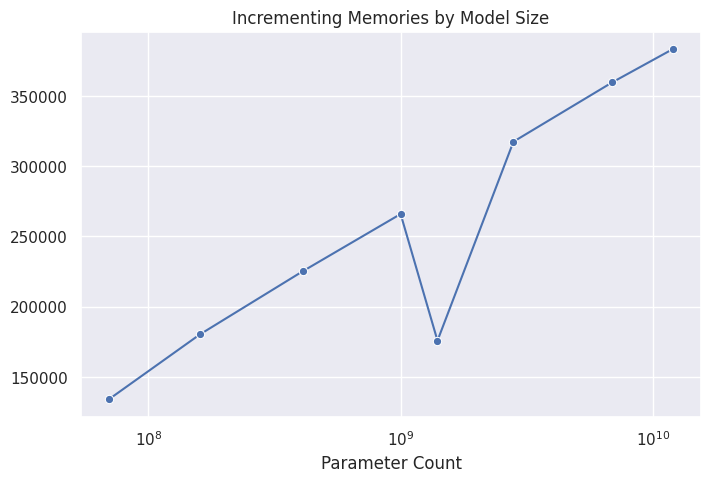

In [5]:
# line splot where the x axis is the "Model" field and the y axis is the count of "true" values "is_incrementing"
sns.set(rc={"figure.figsize": (8, 5)})
fig = sns.lineplot(
    x=formatted_value_counts.keys(),
    y=formatted_value_counts.values(),
    markers=True,
    marker="o",
    # don't use scientifi notation
)
fig.set(xlabel="Parameter Count")
fig.set_title("Incrementing Memories by Model Size")

# Don't use scientific notation
fig.xaxis.get_major_formatter().set_scientific(False)

# log scale x axis
fig.set(xscale="log")

# angle x ticks
# fig.set_xticklabels(fig.get_xticklabels(), rotation=45, horizontalalignment="left")
fig

* mean `num_repeating`
* mean `sequence_duplicates`
* mean `max_frequency`
* avg_frequency
* count is_incrementing
* mean num_repeating
* mean templating_frequency_0.8
* mean templating_frequency_0.9
* mean sequence_perplexity
* mean generation_perplexity

## Generalized Implementation

In [22]:
sample_set = combined_dataframe.sample(1000000)

In [79]:
model_statistics = {}
for param_count in tqdm(split_to_param_count.values()):
    current_model_memories = combined_dataframe[combined_dataframe["Param Count"] == param_count]

    # Replace all -1 cases with zero
    current_model_memories["num_repeating"] = current_model_memories["num_repeating"].replace(-1, 0)
    current_model_memories["is_incrementing"] = current_model_memories["is_incrementing"].replace(-1, 0)
    current_model_memories["sequence_duplicates"] = current_model_memories["sequence_duplicates"].replace(-1, 0)
    current_model_memories["max_frequency"] = current_model_memories["max_frequency"].replace(-1, 0)
    current_model_memories["templating_frequency_0.9"] = current_model_memories["templating_frequency_0.9"].replace(-1, 0)
    current_model_memories["templating_frequency_0.8"] = current_model_memories["templating_frequency_0.8"].replace(-1, 0)

    deduped_memories = current_model_memories[current_model_memories["Deduped"] == True]
    print(param_count)
    deduped_stats = {
        "Mean Repititions": deduped_memories["num_repeating"].mean(),
        "Mean Duplicates": deduped_memories["sequence_duplicates"].mean(),
        "Mean Max Frequency": deduped_memories["max_frequency"].mean(),
        "Count Incrementing": len(deduped_memories[deduped_memories["is_incrementing"] == True]),
        "Incrementing Prevalence": 100 * len(deduped_memories[deduped_memories["is_incrementing"] == True]) / len(deduped_memories),
        "Mean Templating Frequency (0.9)": deduped_memories["templating_frequency_0.9"].mean(),
        "Mean Templating Frequency (0.8)": deduped_memories["templating_frequency_0.8"].mean(),
        "Mean Prompt Perplexity": float(deduped_memories["prompt_perplexity"].mean()),
        "Mean Generation Perplexity": float(deduped_memories["generation_perplexity"].mean()),
        "Mean Sequence Perplexity": float(deduped_memories["sequence_perplexity"].mean()),
    }

    duped_memories = current_model_memories[current_model_memories["Deduped"] == False]
    # print(f"Memories Count: {len(duped_memories)}")
    # print(duped_memories.value_counts(["is_incrementing"]))
    duped_stats = {
        "Mean Repititions": duped_memories["num_repeating"].mean(),
        "Mean Duplicates": duped_memories["sequence_duplicates"].mean(),
        "Mean Max Frequency": duped_memories["max_frequency"].mean(),
        "Count Incrementing": duped_memories[duped_memories["is_incrementing"] == True].shape[0],
        "Incrementing Prevalence": 100 * len(duped_memories[duped_memories["is_incrementing"] == True]) / len(duped_memories),
        "Mean Templating Frequency (0.9)": duped_memories["templating_frequency_0.9"].mean(),
        "Mean Templating Frequency (0.8)": duped_memories["templating_frequency_0.8"].mean(),
        "Mean Prompt Perplexity": float(duped_memories["prompt_perplexity"].mean()),
        "Mean Generation Perplexity": float(duped_memories["generation_perplexity"].mean()),
        "Mean Sequence Perplexity": float(duped_memories["sequence_perplexity"].mean()),
    }
    model_statistics[param_count] = {"Deduped": deduped_stats, "Duped": duped_stats}

print(json.dumps(model_statistics, indent=4))

  0%|          | 0/8 [00:00<?, ?it/s]

/tmp/ipykernel_397621/3127543739.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_model_memories["num_repeating"] = current_model_memories["num_repeating"].replace(-1, 0)
/tmp/ipykernel_397621/3127543739.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_model_memories["is_incrementing"] = current_model_memories["is_incrementing"].replace(-1, 0)
/tmp/ipykernel_397621/3127543739.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

100%|██████████| 9/9 [00:00<00:00, 11.58it/s]


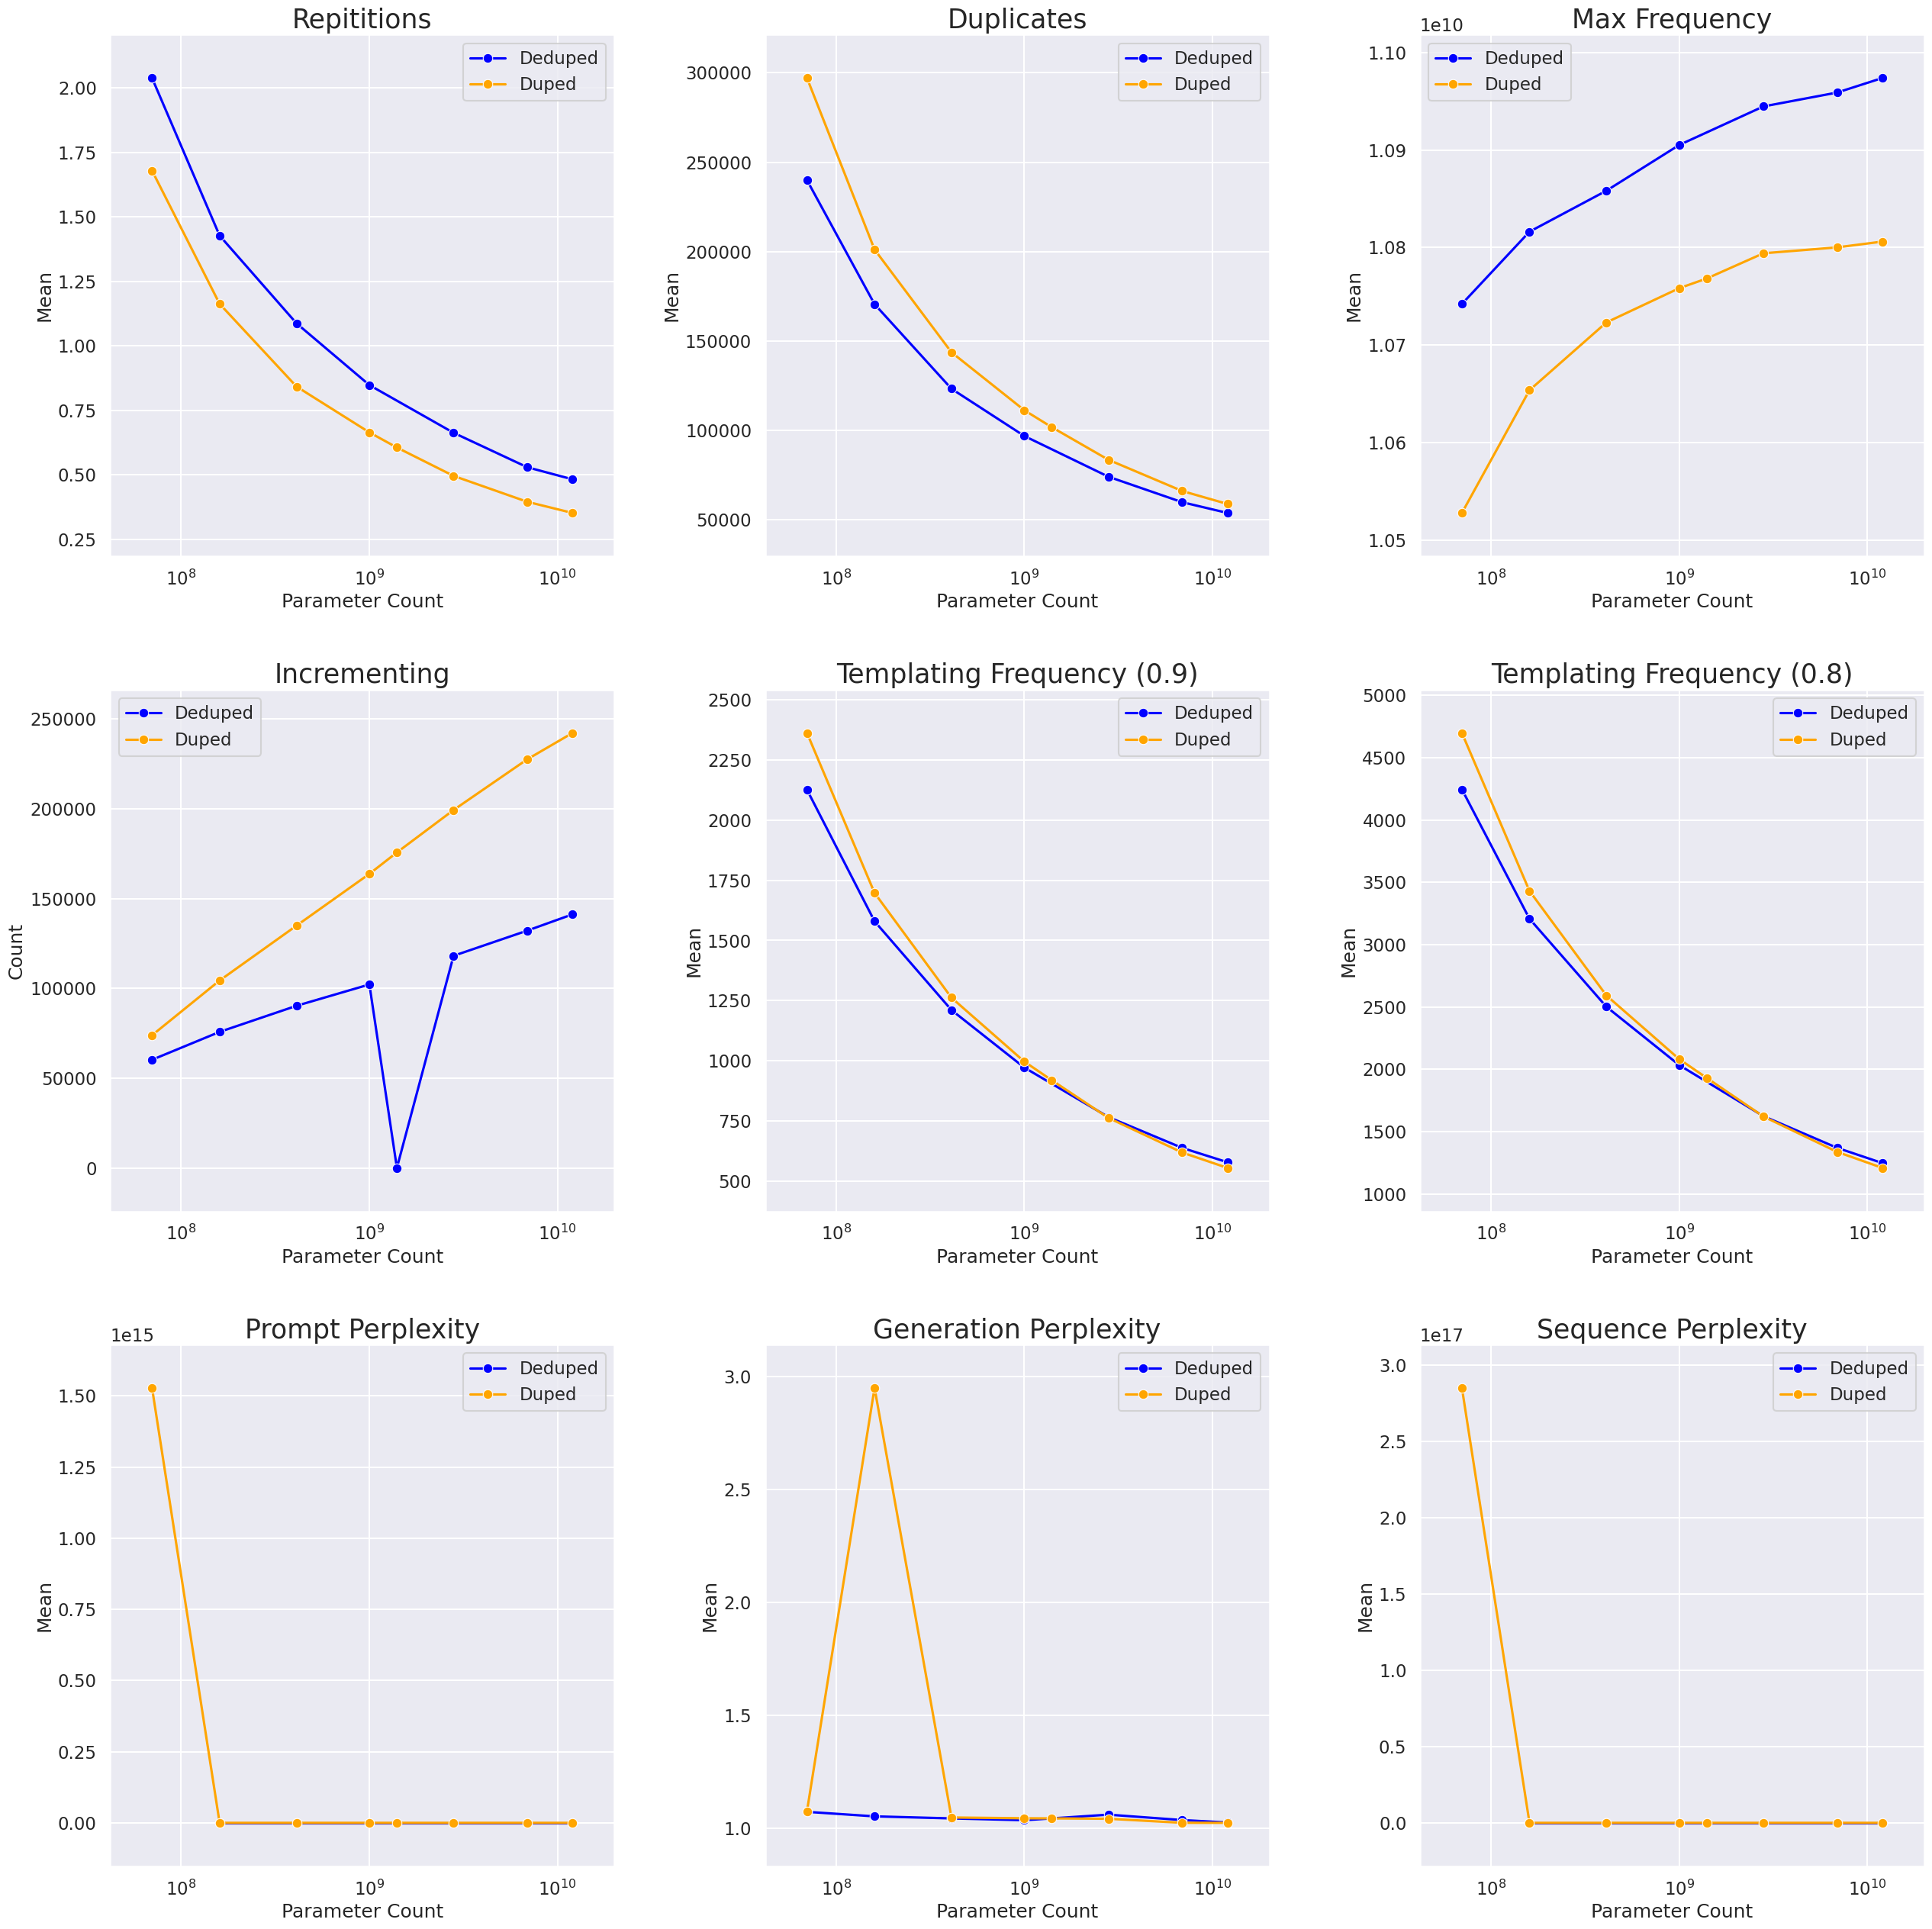

In [78]:
metrics = ["Mean Repititions", "Mean Duplicates", "Mean Max Frequency",
           "Count Incrementing", "Mean Templating Frequency (0.9)",
           "Mean Templating Frequency (0.8)","Mean Prompt Perplexity",
           "Mean Generation Perplexity", "Mean Sequence Perplexity"]

# Create a grid of line charts for each metric
fig, axs = plt.subplots(3, 3, figsize=(27, 27))
fig.tight_layout(pad=5.0)

for metric in tqdm(metrics):
    # Create a line plot for each model size
    grid_x = metrics.index(metric) // 3
    grid_y = metrics.index(metric) % 3

    deduped_model_metrics = [model["Deduped"][metric] for model in model_statistics.values()]
    duped_model_metrics = [model["Duped"][metric] for model in model_statistics.values()]

    sns.lineplot(
        x=list(split_to_param_count.values()),
        y=deduped_model_metrics, ax=axs[grid_x][grid_y],
        color="blue",
        label="Deduped",
        markers=True,
        marker="o",
        )

    sns.lineplot(
        x=list(split_to_param_count.values()),
        y=duped_model_metrics, ax=axs[grid_x][grid_y],
        color="orange",
        label="Duped",
        markers=True,
        marker="o",
        )

    # set title
    axs[grid_x][grid_y].set_xlabel("Parameter Count")
    axs[grid_x][grid_y].set_ylabel(metric.split()[0])
    axs[grid_x][grid_y].set_title(" ".join(metric.split()[1:]))
    axs[grid_x][grid_y].set_xscale("log")
    axs[grid_x][grid_y].title.set_fontsize(25)
    axs[grid_x][grid_y].margins(x=0.1, y=0.1)

    # if "Perplexity" in metric:
    #     axs[grid_x][grid_y].set_yscale("log")
    #     axs[grid_x][grid_y].set_ylabel(metric.split()[0] + " (log scale)")

    # set the legend to the out right if top right corner outside of the graph, otherwise hide
    # if grid_x == 0 and grid_y == 2:
    #     axs[grid_x][grid_y].legend(loc="upper right", bbox_to_anchor=(1.25, 1.0))
    # else:
    #     axs[grid_x][grid_y].get_legend().remove()

    # break

